# 1. Required packages

## For the interactivity I'm using _plotly_ library and _Jupyter Widgets_. 
It allows to prototype dashboard in some way. Hence, for correct execution of the current notebook one has to install the following packages: 
   - [plotly](https://plot.ly/python/) + [cufflinks](https://plot.ly/ipython-notebooks/cufflinks/)
   - [ipywidgets](https://github.com/jupyter-widgets/ipywidgets)

and activate the required extensions for Jupyter. Feel free to do it manually or run the following script.

In [ ]:
# %%bash
# pip install plotly
# pip install cufflinks
# pip install ipywidgets
# jupyter nbextension install --py --sys-prefix widgetsnbextension
# jupyter nbextension install --py --sys-prefix plotlywidget
# jupyter nbextension enable --py --sys-prefix widgetsnbextension
# jupyter nbextension enable --py --sys-prefix plotlywidget

To validate the correct installation and activation of the required packages please execute:

In [1]:
%%bash 
jupyter nbextension list

Known nbextensions:
  config dir: /anaconda3/envs/DL/etc/jupyter/nbconfig
    notebook section
      plotlywidget/extension  enabled 
      jupyter-js-widgets/extension  enabled 


      - Validating: OK
      - Validating: OK


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# 2. Data I/O
We assume that one has already obtained the embeddings for the researched financial statement network. 

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from NetEmbs import *

MODE = "SimulatedData"
DB_PATH = "Simulation/FSN_Data_5k.db"
# CONFIG.ROOT_FOLDER = "UvA/GoogleColab/Optimal 5k/"
CONFIG.ROOT_FOLDER = "Uva/LargeDataset/"
CONFIG.EXPERIMENT = [0, 1]

#  ---------- CONFIG Setting HERE ------------
# .1 Sampling parameters
CONFIG.STRATEGY = "MetaDiff"
CONFIG.PRESSURE = 10
CONFIG.WINDOW_SIZE = 2
CONFIG.WALKS_PER_NODE = 30
CONFIG.WALKS_LENGTH = 10
# .2 TF parameters
CONFIG.STEPS = 100000
CONFIG.EMBD_SIZE = 8
CONFIG.LOSS_FUNCTION = "NegativeSampling"  # or "NCE"
CONFIG.BATCH_SIZE = 256
CONFIG.NEGATIVE_SAMPLES = 512

updateCONFIG(False)
EMBS_PATH = CONFIG.WORK_FOLDER[0]+CONFIG.WORK_FOLDER[1]+CONFIG.WORK_FOLDER[2]

if MODE == "SimulatedData":
#     EMBS_PATH = "UvA/LargeDataset/verMetaDiff_dirCOMBI_walks30_pressure10_1hopFraction0_0/windowSize2/EMB16_batch256_NegSamples512_TFsteps50000_0/"
#     EMBS_PATH = "UvA/MediumDataset/verMetaDiff_dirCOMBI_walks20_pressure30_1hopFraction0_/windowSize2/EMB32_batch64_TFsteps100000_ /"
#     EMBS_PATH = "Simulation_versionMetaDiff_directionCOMBI_walks30_pressure30_window3/TFsteps100000batch64_emb32/"
    embs = pd.read_pickle(EMBS_PATH+"Embeddings.pkl")
    print("Embeddings have been uploaded to memory!")
    d = upload_data(DB_PATH, limit=None)
    d = prepare_data(d)
    print("Supported information has been uploaded to memory!")

if MODE == "RealData":
    import extras
    import analysis
    EMBS_PATH = "model/15108_2017_versionMetaDiff_directionCOMBI_walks31_pressure30_window3/TFsteps100000batch64_emb32/"
    embs = pd.read_pickle(EMBS_PATH+"cache/Embeddings.pkl")
        # //////// TODO UPLOAD your data HERE \\\\\\\\\\
#     d = analysis.analysis("14082_2017")
    d = extras.getData("15108_2017")
        # //////// END  \\\\\\\\\\
    # TODO pay attention for the split argument below!
    if "Value" in list(d):
        need_split = True
    else:
        need_split = False
    d = prepare_dataMarcel(d, split=need_split)
#     Here we drop the duplicate of GroundTruth in the DataFrame with supported info, because we have it in Embs DataFrame
    if "GroundTruth" in list(d):
        d.drop("GroundTruth", axis=1, inplace=True)
print("Shape of uploaded Dataset is ", d.shape)

Config file has been updated!
Embeddings have been uploaded to memory!
Final shape of DataFrame is  (29239, 9)
Supported information has been uploaded to memory!
Shape of uploaded Dataset is  (29239, 9)


# The number of samples per each GroundTruth

In [4]:
def plotStat(df, context="paper_full", labels=("Ground Truth", "Number of processes"), title=None, set_title=None):
    df_vis = df.groupby(["GroundTruth"])[['ID']].count().rename({"ID": "Number of processes"}, axis=1).reset_index()
    print(list(df_vis))
    dpi = 140
    fig_size = (13, 10)
    #     set_font(14, True)
    if context == "paper_half":
        sns.set_context("paper", font_scale=1.5)
        fig_size = (6.4, 4.8)
    if context == "paper_full":
        sns.set_context("paper", font_scale=1.8)
    if context == "talk_half":
        sns.set_context("paper", font_scale=3.5)
    if context == "talk_full":
        sns.set_context("paper", font_scale=2)
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(111)
    df_vis.plot.bar(ax=ax, legend=False)
#     sns.barplot(x="GroundTruth", y="Number of processes", data=df_vis, color="cornflowerblue", ax=ax)
    df_vis
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
#     plt.xticks(rotation=30)
    ax.set_xlabel(labels[0])
    ax.yaxis.set_ticks_position('left')
    ax.set_ylabel(labels[1])
    if set_title is not None:
        ax.set_title(set_title)
    if title is not None:
        fig.savefig("img/Modelling/" + title + labels[0] + labels[1] + "_for_" + context + ".png", bbox_inches="tight", dpi=dpi, pad_inches=0.05)
    plt.show(fig)
    plt.close(fig)

['GroundTruth', 'Number of processes']


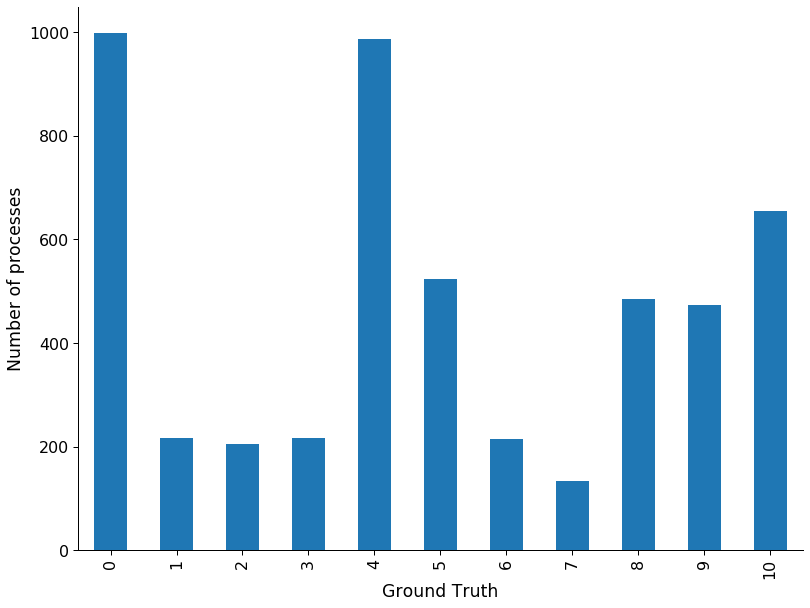

In [5]:
plotStat(embs)

# 3. Interactive visualization

### 3.2 Visualization

In [6]:
from __future__ import print_function
# Standard plotly imports
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, plot, init_notebook_mode
# Using plotly + cufflinks in offline mode
import cufflinks

cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
from ipywidgets import interactive, HBox, VBox, widgets

### Clustering here

In [10]:
embs.GroundTruth.nunique()

11

In [173]:
N_CLS = 12
embs = cl_Agglomerative(embs, N_CLS)

First row of Data: 
 [-0.38152471 -0.34886238  0.20825255  0.32573476  0.44090793  0.31327802
  0.43619904 -0.31693727]


In [ ]:
set_font()

In [194]:
from NetEmbs.Vis.helpers import set_font, getColors_Markers
from NetEmbs.Vis.words_cloud import findMostCommonFAs_v2
# Label text
description = widgets.Label(
        value=''
    )
# WordCouds area
wordCloudsOutput = widgets.Output()
# Table with JournalEntries data
table_titles = ["ID", "FA_Name", "Credit", "Debit", "label"]
format_style = [[None], [None], ['.4f'], ['.4f'], [None]]

if MODE == "RealData":
    table_titles = ["ID", "FA_Name", "accountDesc", "Credit", "Debit", "label"]
    format_style = [[None], [None], [None], ['.4f'], ['.4f'], [None]]

t = go.FigureWidget([go.Table(
    header=dict(values=table_titles,
                fill = dict(color='#E5F1DC'),
                align = ['center'] * 5),
    cells=dict(values=[],
               format = format_style,
#                fill = dict(color='white'),
               align = ['center'] * 5))],
                    layout = go.Layout(
                            title="Journal Entries",
                            autosize=True,
                            width=1000,
                            height=400))  
# Scatter plot
N_COLORS = 10
WORD_CLOUD_LABEL = "FA_Name"
LEGEND_TITLE = "GroundTruth"
# LEGEND_TITLE = "label"

tmp_p_see = None
# For selection via multiple traces... stupid way.
indexes = []
tr_nums = 0


def interactiveScatter(df, df_info, legend_title="label"):
    """Create FigureWidget with the scatter plot for the given DataFrame"""
    scatter_data = list()
    cmap, mmap = getColors_Markers(keys=df[legend_title].unique(), cm="tab10", n_colors=N_COLORS, markers=["circle", "diamond", "square"])
    for name, group in df.groupby(legend_title):
        scatter_data.append(go.Scatter(x=group.x, y=group.y, mode='markers', name=name, 
                                    text = group.apply(lambda row: f"ID={row.ID},   GroundTruth={row.GroundTruth}", axis=1),
                                    customdata = group.index.to_list(),
                                    marker=dict(color=cmap[name][1], 
                                                symbol=mmap[name])))
    f = go.FigureWidget(data=scatter_data,
                       layout = go.Layout(
                           title=f"t-SNE visualisation with coloring based on {legend_title}",
        hovermode='closest',
        autosize=True,
        width=1000,
        height=700))
    
    def printSignature(trace, points, *args):
        if len(points.point_inds)>0:
            ids = trace.customdata[points.point_inds[0]]
            row = df.iloc[ids]
            description.value = f"ID={row.ID},   GroundTruth={row.GroundTruth}"
    def selectBP(trace, points, *args):
        if len(points.point_inds)>0:
            ids = trace.customdata[points.point_inds[0]]
            row = df.iloc[[ids]]
            chosen_bps = df_info.merge(row, on="ID")
            wordCloudsOutput.clear_output()
            t.data[0].cells.values = [chosen_bps[col] for col in t.data[0].header.values]
    
    def filterRows(selected_ids):
        row = df.iloc[selected_ids]
        chosen_bps = df_info.merge(row, on="ID")
        return chosen_bps
    def updateTable(chosen_bps):
        t.data[0].cells.values = [chosen_bps[col] for col in t.data[0].header.values]
    def showClouds(chosen_bps):
        wordCloudsOutput.clear_output()
        with wordCloudsOutput:
            findMostCommonFAs_v2(chosen_bps, LEGEND_TITLE, WORD_CLOUD_LABEL, sort_mode="freq", vis=True, n_top=4)
    scatters = f.data
    max_traces = len(scatters)
    def selectBPs(trace,points,selector):
        global indexes
        global tr_nums
#         print(f"For trace index={points.trace_index} tr_nums is {tr_nums}")
        if not points.point_inds:
            pass
        else:
            indexes.extend([trace.customdata[cur_point] for cur_point in points.point_inds])
        tr_nums = tr_nums+1
        if tr_nums==max_traces:
            selected_data = filterRows(indexes)
            updateTable(selected_data)
            showClouds(selected_data)
            indexes = []
            tr_nums = 0
    # Hover text: ID and GroundTruth
    for scatter in scatters:
        scatter.hoverinfo = 'text'
        scatter.on_hover(printSignature) 
        scatter.on_click(selectBP)
        scatter.on_selection(selectBPs)

    # Selection
    return f
# @interact(Coloring=['label', 'GroundTruth'])
# def update(Coloring="label"):
#     print(Coloring)
#     f_scatter = interactiveScatter(embs, Coloring)
#     return VBox([description, f_scatter])
f_scatter = interactiveScatter(embs, d, LEGEND_TITLE)
VBox([description, f_scatter, t, wordCloudsOutput])

    'data': [{'customdata': [27, 34, 38, ..., 5031, 5034, 5035]…

In [9]:
print(f"Number of FAs is {d.FA_Name.nunique()}, \nNumber of BPs is {embs.shape[0]}")

Number of FAs is 663, 
Number of BPs is 5109


# Time-Series modeling

In [175]:
labels_to_titles = embs.groupby("label").GroundTruth.agg(pd.Series.mode).to_dict()
labels_to_titles

{0: 'Goods delivery',
 1: 'Collections',
 2: 'Collections',
 3: 'Sales tax',
 4: 'Payroll',
 5: 'Sales 21 btw',
 6: 'Disbursement',
 7: 'Depreciation',
 8: 'Payroll Disbursement',
 9: 'Fixed Assets',
 10: 'Sales 6 btw',
 11: 'Purchase'}

In [10]:
def crosscorr(data_x, data_y, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return data_x.corr(data_y.shift(lag, freq="D"))

Our initial hypotheis is that sub-groups of business process within a company should have some kind of cross correlation (e.g. goods delivery business process follows after sale business process). For deeper investigation of that hypothesis we are going to aggregate given Journal Entries (aka input raw data) based on the predicted cluster label and to build time-series from these groups w.r.t. to the transaction time.

In [176]:
# TODO helper uploader for obtain Time column. 
if MODE=="SimulatedData":
    df_all = d.drop(["Signature", "Name"], axis=1)
    print(f"Shape of supported info is {df_all.shape}, shape of embs DataFrame is {embs.shape}")
    df_all = df_all.merge(embs, on="ID")
    print(f"After merge the shape is {df_all.shape}")
    df_all = df_all.groupby(["ID", "FA_Name", "from"], as_index=False).aggregate({"amount": lambda x: np.sum(x), 
                                "Time": "first",
                              "GroundTruth": "first",
                              "label": "first",
                              "x": "first",
                              "y": "first"}) \
                        .sort_values("Time", ascending=True)
if MODE=="RealData":
    d["Date"] = pd.to_datetime(d["Date"],format='%Y-%m-%d')
#     df_all = d.groupby("ID", as_index=False).aggregate({"amount": lambda x: np.sum(x)/2.0, 
#                                "Date": "first"}).merge(embs, on="ID").sort_values("Date", ascending=True)
    df_all = d.groupby(["ID", "FA_Name", "from"], as_index=False)\
                .aggregate({"amount": lambda x: np.sum(x), 
                            "Date": "first",
                           "accountDesc": "first"})\
                .merge(embs, on="ID")\
                .sort_values("Date", ascending=True)
    df_all.set_index(df_all.Date, inplace=True)
df_all.head(2)

Shape of supported info is (29239, 7), shape of embs DataFrame is (5109, 7)
After merge the shape is (29239, 13)


,ID,FA_Name,from,amount,Time,GroundTruth,label,x,y
0,7,FixedAssets,False,52.184404,0.67896,Fixed Assets,9,8.510545,-57.541683
1,7,NoisyLeftFA_kbfq,True,0.021187,0.67896,Fixed Assets,9,8.510545,-57.541683


## Add DateTimeIndex to simulated data

In [177]:
def addDateTimeIndex(df):
    df["SimulatedTime"] = df["Time"]
    df["Time"] = df["Time"].apply(lambda x: np.datetime64('2019-01-01')+np.timedelta64(int(x*205.7), 'm'))
    return df.set_index("Time")
if MODE=="SimulatedData":
    df_all = addDateTimeIndex(df_all)
#     embs = addDateTimeIndex(embs)
df_all["flow"] = df_all["from"].apply(lambda x: {False: "inflow", True: "outflow" }[x])

## Get part of data with required labe/GroundTruth

In [13]:
def filterData(df, query=[["Sales 21 btw", "Sales 6 btw"], ["Collections"]], on="GroundTruth"):
    result = list()
    for q in query:
        result.append(df_all[df_all[on].isin(q)])
        result[-1].name=str(q)[1:-1]
        if on == "label":
            result[-1].name+=" cluster"
    return tuple(result)

def filterData_v3(df, 
                  query=[{"select": ["Sales 21 btw", "Sales 6 btw"], 
                              "_with": {"FA_Name": "Revenue", "from": True}}, 
                 {"select": ["Collections"], "_with": None}], 
                  on="GroundTruth"):
    result = list()
    for q in query:
        postfix = {"FA_Name": None, "flow": None}
        if q["select"] is None or q["select"]==["ALL"] or q["select"]=="ALL":
            cur_df = df
        else:
            cur_df = df[df[on].isin(q["select"])]
        if q["_with"] is not None:
            for key, value in q["_with"].items():
                try:
                    cur_df = cur_df[cur_df[key]==value]
                    postfix[key] = str(value)
                except KeyError as e:
                    raise(f"{a} is not in a columns titles!")
        result.append(cur_df)
        result[-1].name=str(q["select"])[1:-1]
        if on == "label":
            result[-1].name+=" cluster"
            if len(q["select"])>1:
                result[-1].name+="s"
        if postfix["FA_Name"] is not None:
            result[-1].name+=f" – {postfix['FA_Name']}"
        if postfix["flow"] is not None:
            result[-1].name+=f"({postfix['flow']})"
    if len(result)==1:
        return result[0]
    else:
        return tuple(result)

In [60]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import numpy as np
from sklearn import linear_model
def plotAmounts(DFs, aggtitle="Default signals", corr_score=None, filename="amounts_plot"):
    """Helper funciton to plot a few DataFrame in one plotly graph"""
    if corr_score is not None:
        aggtitle = aggtitle + ".     Correlation: "+str(round(corr_score, 3))
    if len(DFs)>1:
            fig2 = go.Figure(data=[go.Scatter(x=df.index,
            y=df.amount,
            name=df.name
            ) for df in DFs], 
            layout = go.Layout(width=1200,
    height=400, showlegend=True, title=go.layout.Title(text=aggtitle), hovermode='closest', 
                               legend=dict(orientation="h", font=dict(size=18), xanchor='center', x=0.5, y=-0.1),
                              font=dict(size=18)))
    else:
            fig2 = go.Figure(data=go.Scatter(x=DFs.index,
            y=DFs.amount,
            name=DFs.name, 
            layout = go.Layout(width=1200,
            height=400, showlegend=True, title=go.layout.Title(text=aggtitle), hovermode='closest')))
    iplot(fig2)
    fig2.write_image(filename+".pdf")

## Resample our TimeSeries with Dayly/Weekly/Monthly frequencies

## All in One function

In [41]:
def NRMSD(true_labels, pred_labels):
    mse = mean_squared_error(true_labels, pred_labels)
    return np.sqrt(mse)/(np.subtract(*np.percentile(true_labels, [75, 25])))

In [136]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
NUM_EXP = 5

def plotScatter(df_train, df_test=None, context="paper_full", labels=("Dimension X", "Dimension Y"), title=None, set_title=None):
    dpi = 140
    fig_size = (13, 10)
    #     set_font(14, True)
    if context == "paper_half":
        sns.set_context("paper", font_scale=1.5)
        fig_size = (6.4, 4.8)
    if context == "paper_full":
        sns.set_context("paper", font_scale=1.8)
    if context == "talk_half":
        sns.set_context("paper", font_scale=3.5)
    if context == "talk_full":
        sns.set_context("paper", font_scale=2)
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(111)
#     sns.lmplot(data=df_train, x="amount_X", y="amount_Y", ax=ax, scatter_kws=dict(s=85, alpha=0.75))
    sns.regplot(x=df_train.iloc[:, 0], y=df_train.iloc[:, 1], ax=ax, scatter_kws=dict(s=85, alpha=0.75), line_kws=dict(alpha=0.8))
    if df_test is not None:
        sns.regplot(x=df_test.iloc[:, 0], y=df_test.iloc[:, 1], ax=ax, color="red")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel(labels[0])
    ax.yaxis.set_ticks_position('left')
    ax.set_ylabel(labels[1])
    if set_title is not None:
        ax.set_title(set_title)
    if title is not None:
        fig.savefig(title + labels[0] + labels[1] + "_for_" + context + ".png", bbox_inches="tight", dpi=dpi, pad_inches=0.05)
    plt.show(fig)
    plt.close(fig)
    
def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.divide(np.abs((y_true - y_pred)), y_true, out=np.zeros_like(y_true), where=y_true!=0)) * 100

legend_postfix = {"W": ", weekly", "D": ", daily", "M": ", monthly", "2D": ", 2 days"}

def constructSignals(df_all, shift=(0, 0), query=[{"select": [2], "_with": None}, {"select": [4], "_with": None}], 
                     on="label", agg_period="W", title = None, legend=None, metric="MSE"):
    # Predicted labels
    agg_title = "Aggregated signals"
    left, right = filterData_v3(df_all, query=query, on=on)
#     plotAmounts([sales, collections], "Original signals, without aggregation")
    print("Started aggregation...")
#     Make required shifts
    left_agg = left.shift(shift[0], freq="D")
    right_agg = right.shift(shift[1], freq="D")
#     Aling TimeIndexes for correct aggregation.
    st_date = max(left_agg.index[0], right_agg.index[0])
    end_date = min(left_agg.index[-1], right_agg.index[-1])
    left_agg = left_agg[(left_agg.index>=st_date) & (left_agg.index<=end_date)]
    right_agg = right_agg[(right_agg.index>=st_date) & (right_agg.index<=end_date)]
#     Makre required aggregation
    left_agg = left_agg.resample(agg_period).agg({"amount": sum})
    right_agg = right_agg.resample(agg_period).apply({"amount": sum})
    if legend is not None:
        left_agg.name = legend[0]+legend_postfix[agg_period]
        right_agg.name = legend[1]+legend_postfix[agg_period]
        agg_title+=legend_postfix[agg_period]
#     Add info about aggregation period to legen texts
    else:
        try:
            left_agg.name = left.name+legend_postfix[agg_period]
            right_agg.name = right.name+legend_postfix[agg_period]
            agg_title+=legend_postfix[agg_period]
        except KeyError as e:
    #         print(f"Could not intepret {agg_period} for adding postfix to legend text... Use the default ones.." )
            left_agg.name = left.name+", "+ agg_period
            right_agg.name = right.name+", "+ agg_period
            agg_title+=", "+ agg_period
    plotAmounts([left_agg, right_agg], agg_title, filename=title+"_"+agg_period, corr_score=left_agg.amount.corr(right_agg.amount))
    print(f"Correlation for given query and given shifts {shift} is \
          {left_agg.amount.corr(right_agg.amount)}")

    all_data = left_agg.join(right_agg, lsuffix="_X", rsuffix="_Y", how="inner")
    if metric in ["MSE", "RMSE"]:
        from sklearn.preprocessing import minmax_scale
        all_data["amount_Y"] = minmax_scale(all_data["amount_Y"])
        all_data["amount_X"] = minmax_scale(all_data["amount_X"])
    scores = list()
    lr = LinearRegression()
#     train, test = train_test_split(all_data, test_size=0.2, random_state=1)
#     lr.fit(train.iloc[:, 0].values.reshape(-1, 1), train.iloc[:, 1].values.reshape(-1, 1))
#     print("Coefficients in constructed linear regression model are: :", lr.coef_)
#     tax_predicted = lr.predict(test[["amount_X"]])
#     print(f"MAPE score is {MAPE(test[['amount_Y']], tax_predicted)}")
#     plotScatter(train, test, labels=(left_agg.name, right_agg.name))
    for r_s in range(NUM_EXP):
#         Make new split
        train, test = train_test_split(all_data, test_size=0.2, random_state=r_s)
        lr.fit(train.iloc[:, 0].values.reshape(-1, 1), train.iloc[:, 1].values.reshape(-1, 1))
#         print("Coefficients in constructed linear regression model are: :", lr.coef_)
        tax_predicted = lr.predict(test[["amount_X"]])
        if metric=="MSE":
            scores.append(mean_squared_error(test[['amount_Y']], tax_predicted))
        elif metric=="RMSE":
            scores.append(np.sqrt(mean_squared_error(test[['amount_Y']], tax_predicted)))
        elif metric=="NRMSD":
            scores.append(NRMSD(test[['amount_Y']], tax_predicted))
#     try:
#         scores = cross_val_score(lr, all_data.iloc[:, 0].values.reshape(-1, 1), all_data.iloc[:, 1].values.reshape(-1, 1), \
#                          cv=3, scoring="neg_mean_absolute_error")
#     except Exception as e:
#         raise Exception("Something went wrong in linear regression")
    print(np.mean(scores))
    score = f"Average {metric} is {np.round(np.mean(scores), 3)}"
    if title is not None:
        plotScatter(all_data, labels=(left_agg.name, right_agg.name), title=title+"_"+agg_period, set_title=score)
    else:
        plotScatter(all_data, labels=(left_agg.name, right_agg.name), title=title, set_title=score)
    plt.show()
    return all_data
#     return left_agg, right_agg

In [ ]:
legend_postfix = {"W": ", weekly", "D": ", daily", "M": ", monthly", "2D": ", 2 days"}
legend_postfix = {"W": ", weekly", "D": ", daily", "M": ", monthly", "2D": ", 2 days"}


def constructSignals_v2(df_all, shift=(0, 0), query=[{"select": [2], "_with": None}, {"select": [4], "_with": None}],
                        on="label", agg_period="W", title=None, legend=None, metric="MSE", scale_data=True):
    # Predicted labels
    agg_title = "Aggregated signals"
    left, right = filterData_v3(df_all, query=query, on=on)
    #     Make required shifts
    left_agg = left.shift(shift[0], freq="D")
    right_agg = right.shift(shift[1], freq="D")
    #     Aling TimeIndexes for correct aggregation.
    st_date = max(left_agg.index[0], right_agg.index[0])
    end_date = min(left_agg.index[-1], right_agg.index[-1])
    left_agg = left_agg[(left_agg.index >= st_date) & (left_agg.index <= end_date)]
    right_agg = right_agg[(right_agg.index >= st_date) & (right_agg.index <= end_date)]
    #     Makre required aggregation
    left_agg = left_agg.resample(agg_period).agg({"amount": sum})
    right_agg = right_agg.resample(agg_period).apply({"amount": sum})
    if legend is not None:
        left_agg.name = legend[0] + legend_postfix[agg_period]
        right_agg.name = legend[1] + legend_postfix[agg_period]
        agg_title += legend_postfix[agg_period]
    #     Add info about aggregation period to legen texts
    else:
        try:
            left_agg.name = left.name + legend_postfix[agg_period]
            right_agg.name = right.name + legend_postfix[agg_period]
            agg_title += legend_postfix[agg_period]
        except KeyError as e:
            left_agg.name = left.name + ", " + agg_period
            right_agg.name = right.name + ", " + agg_period
            agg_title += ", " + agg_period

    plotAmounts([left_agg, right_agg], agg_title, filename=title + "_" + agg_period,
                corr_score=left_agg.amount.corr(right_agg.amount))
    print(f"Correlation for given query and given shifts {shift} is \
          {left_agg.amount.corr(right_agg.amount)}")

    all_data = left_agg.join(right_agg, lsuffix="_X", rsuffix="_Y", how="inner")
    if scale_data:
        from sklearn.preprocessing import minmax_scale
        all_data["amount_Y"] = minmax_scale(all_data["amount_Y"])
        all_data["amount_X"] = minmax_scale(all_data["amount_X"])
    return all_data


def NRMSD(true_labels, pred_labels):
    mse = mean_squared_error(true_labels, pred_labels)
    return np.sqrt(mse) / (np.subtract(*np.percentile(true_labels, [75, 25])))


def evaluate_model(df, metric="RMSE", n_runs=5):
    scores = list()
    lr = LinearRegression()
    #     train, test = train_test_split(all_data, test_size=0.2, random_state=1)
    #     lr.fit(train.iloc[:, 0].values.reshape(-1, 1), train.iloc[:, 1].values.reshape(-1, 1))
    #     print("Coefficients in constructed linear regression model are: :", lr.coef_)
    #     tax_predicted = lr.predict(test[["amount_X"]])
    #     print(f"MAPE score is {MAPE(test[['amount_Y']], tax_predicted)}")
    #     plotScatter(train, test, labels=(left_agg.name, right_agg.name))
    if "amount_X" not in list(df) or "amount_Y" not in list(df):
        raise KeyError(f"Could not find the columns with X and Y in the given dataset... Titles are {list(df)}, while "
                       f"'amount_X' and 'amount_Y' required!")
    for r_s in range(n_runs):
        #         Make new split
        train, test = train_test_split(df, test_size=0.2, random_state=r_s)
        lr.fit(train.iloc[:, 0].values.reshape(-1, 1), train.iloc[:, 1].values.reshape(-1, 1))
        #         print("Coefficients in constructed linear regression model are: :", lr.coef_)
        tax_predicted = lr.predict(test[["amount_X"]])
        if metric == "MSE":
            scores.append(mean_squared_error(test[['amount_Y']], tax_predicted))
        elif metric == "RMSE":
            scores.append(np.sqrt(mean_squared_error(test[['amount_Y']], tax_predicted)))
        elif metric == "NRMSD":
            scores.append(NRMSD(test[['amount_Y']], tax_predicted))
    return scores

# Financial account and which BPs are operating with them

In [197]:
df_all.groupby(["FA_Name", "from"])["GroundTruth"].agg(["count", "unique"]).sort_values(["count", "from"], ascending=False).head(20)

,,count,unique
FA_Name,from,,
Tax,True,1484,"[Sales 21 btw, Payroll, Sales 6 btw]"
Cash,False,1205,"[Disbursement, Collections]"
TradeReceivables,True,999,[Collections]
Inventory,True,986,[Goods delivery]
CostOfSales,False,986,[Goods delivery]
Revenue,True,960,"[Sales 21 btw, Sales 6 btw]"
TradeReceivables,False,960,"[Sales 21 btw, Sales 6 btw]"
Cash,True,868,"[Sales tax, Payroll Disbursement]"
Tax,False,654,[Sales tax]


# Tax plausible relationship from Marcel's paper

In [142]:
TAX_REVENUE_DF = pd.DataFrame()

## Tax vs. Revenue based on FA Names
Credit-debit model (CD) which uses only the in- and outflow but no process information

Started aggregation...


Correlation for given query and given shifts (0, 0) is           0.8173094111508721
0.11171833857038567


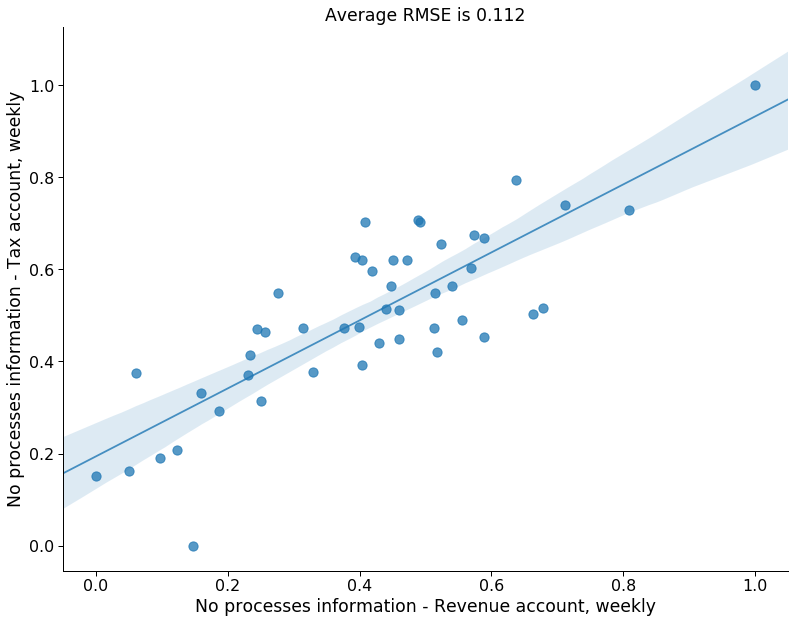

In [143]:
cur_result = constructSignals(df_all, query=[{"select": ["ALL"], 
                              "_with": {"FA_Name": "Revenue"}}, 
                                {"select": ["ALL"], "_with": {"FA_Name": "Tax"}}], on="label", agg_period="W", 
                title="img/Modelling/latest/CD_Model_Tax-Revenue_",
                legend=["No processes information - Revenue account", "No processes information - Tax account"],
                metric="RMSE")
TAX_REVENUE_DF = TAX_REVENUE_DF.append(cur_result.assign(Model="CD Model"))

## Tax vs. Revenue based on the GroundTruth

Started aggregation...


Correlation for given query and given shifts (0, 0) is           0.887990238888077
0.006867530914936737


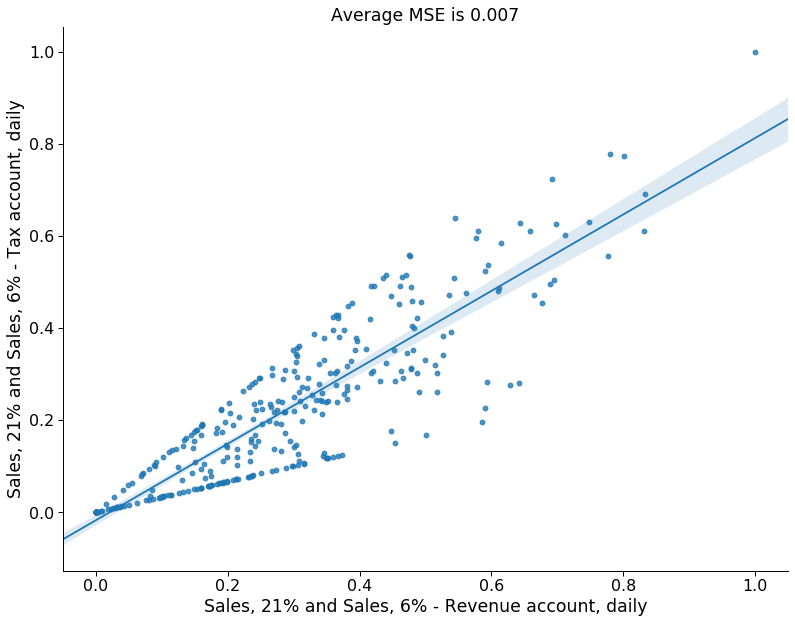

In [68]:
# ~Sales 6 btw
constructSignals(df_all, query=[{"select": ["Sales 21 btw", "Sales 6 btw"], 
                              "_with": {"FA_Name": "Revenue"}}, 
                                {"select": ["Sales 21 btw", "Sales 6 btw"], "_with": {"FA_Name": "Tax"}}], 
                              on="GroundTruth", agg_period="D", title="GroundTruth_Tax-Revenue_",
                legend=["Sales, 21% and Sales, 6% - Revenue account", "Sales, 21% and Sales, 6% - Tax account"],
                metric="RMSE")

## Tax vs. Revenue based on the Sales *as-expert*-cluster

In [55]:
def check_is_sale(df):
    return pd.Series({"ID": df.ID.values[0], "is_Sale": ("Revenue" in df[df["from"]==True].FA_Name.unique()) and ("TradeReceivables" in df[df["from"]==False].FA_Name.unique())})
expert_sales = df_all.reset_index()\
        .merge(df_all.groupby("ID", as_index=False).apply(check_is_sale), on="ID", left_index=True)\
        .set_index("Time", drop=True)

Started aggregation...


Correlation for given query and given shifts (0, 0) is           0.9485087812596132
0.08717905707652981


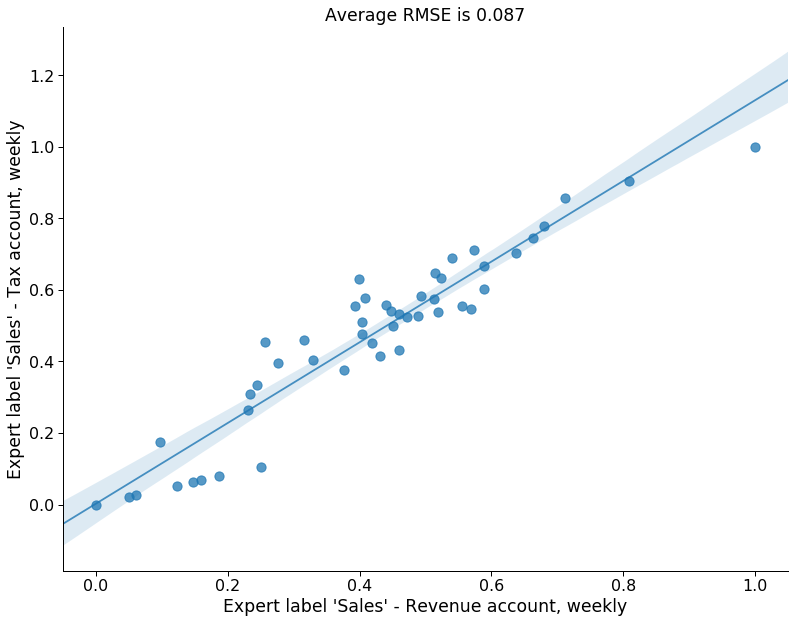

In [144]:
cur_result = constructSignals(expert_sales, query=[{"select": [True], 
                              "_with": {"FA_Name": "Revenue"}}, 
                                {"select": [True], "_with": {"FA_Name": "Tax"}}], agg_period="W", on="is_Sale",
                 title="img/Modelling/latest/expertFSN_Tax-Revenue_",
                 legend=["Expert label 'Sales' - Revenue account", "Expert label 'Sales' - Tax account"],
                    metric="RMSE")
TAX_REVENUE_DF = TAX_REVENUE_DF.append(cur_result.assign(Model="Expert labels FSN model"))

## Tax vs. Revenue based on predicted labels
And, finally a model which uses all the information of the **financial statement network** (FSN) to model plausible relationships.

In [23]:
labels_to_titles

{0: 'Collections',
 1: 'Goods delivery',
 2: 'Sales 21 btw',
 3: 'Sales tax',
 4: 'Payroll',
 5: 'Purchase',
 6: 'Disbursement',
 7: 'Depreciation',
 8: 'Payroll Disbursement',
 9: 'Fixed Assets',
 10: 'Sales 6 btw'}

Started aggregation...


Correlation for given query and given shifts (0, 0) is           0.9485087812596132
0.08717905707652981


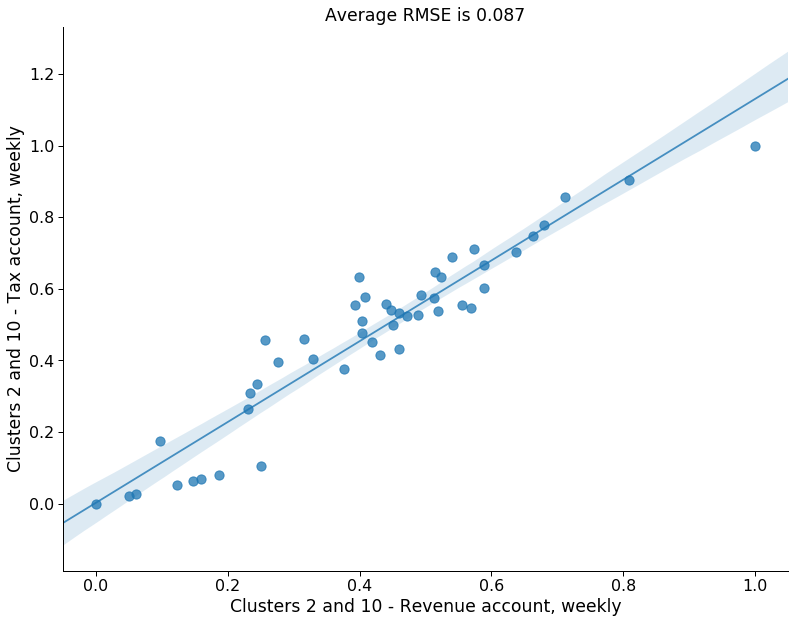

Started aggregation...


Correlation for given query and given shifts (0, 0) is           0.987911911348207
0.02809325789190568


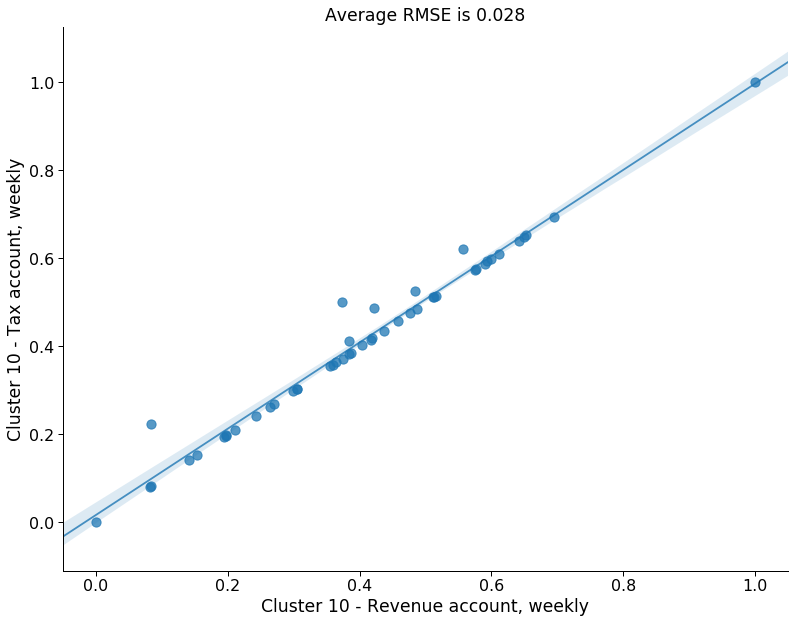

In [145]:
# ~Sales both
cur_result = constructSignals(df_all, query=[{"select": [2, 10], 
                              "_with": {"FA_Name": "Revenue"}}, 
                                {"select": [2, 10], "_with": {"FA_Name": "Tax"}}], on="label", agg_period="W", 
                    title="img/Modelling/Latest/aFSN_Tax-Revenue_",
                    legend=["Clusters 2 and 10 - Revenue account", "Clusters 2 and 10 - Tax account"],
                metric="RMSE")
TAX_REVENUE_DF = TAX_REVENUE_DF.append(cur_result.assign(Model="Predicted labels FSN model"))
# Sales 6
# ~Sales both
cur_result = constructSignals(df_all, query=[{"select": [10], 
                              "_with": {"FA_Name": "Revenue"}}, 
                                {"select": [10], "_with": {"FA_Name": "Tax"}}], on="label", agg_period="W", 
                    title="img/Modelling/Latest/aFSN_Tax6-Revenue_",
                    legend=["Cluster 10 - Revenue account", "Cluster 10 - Tax account"],
                metric="RMSE")
TAX_REVENUE_DF = TAX_REVENUE_DF.append(cur_result.assign(Model="Predicted labels FSN model, finer structure"))

In [235]:
def plotRegression(df, context="talk_full", labels = ["Outflow from Revenue", "Outflow from Tax"], title=None):
    dpi = 140
    fig_size = (11, 11)
    #     set_font(14, True)
    if context == "paper_half":
        sns.set_context("paper", font_scale=1.5)
        fig_size = (6.4, 4.8)
    if context == "paper_full":
        sns.set_context("paper", font_scale=1.8)
    if context == "talk_half":
        sns.set_context("paper", font_scale=3.5)
    if context == "talk_full":
        sns.set_context("paper", font_scale=2)
    cur_plot = sns.lmplot(x="amount_X", y="amount_Y", col="Model", data=df, col_wrap=2, height=5, aspect=1.5, scatter_kws=dict(s=70, alpha=0.75), line_kws=dict(alpha=0.8))\
        .set_titles(col_template = '{col_name}')\
        .set_xlabels(labels[0])\
        .set_ylabels(labels[1])\
        .set(xlim=(0, 1), ylim=(0, 1))
    cur_plot.fig.subplots_adjust(hspace=0.3, wspace=0.1)
    if title is not None:
        cur_plot.savefig(title + "RegressionPlot_for_" + context + ".png", bbox_inches="tight", dpi=dpi, pad_inches=0.05)
    plt.show(cur_plot)

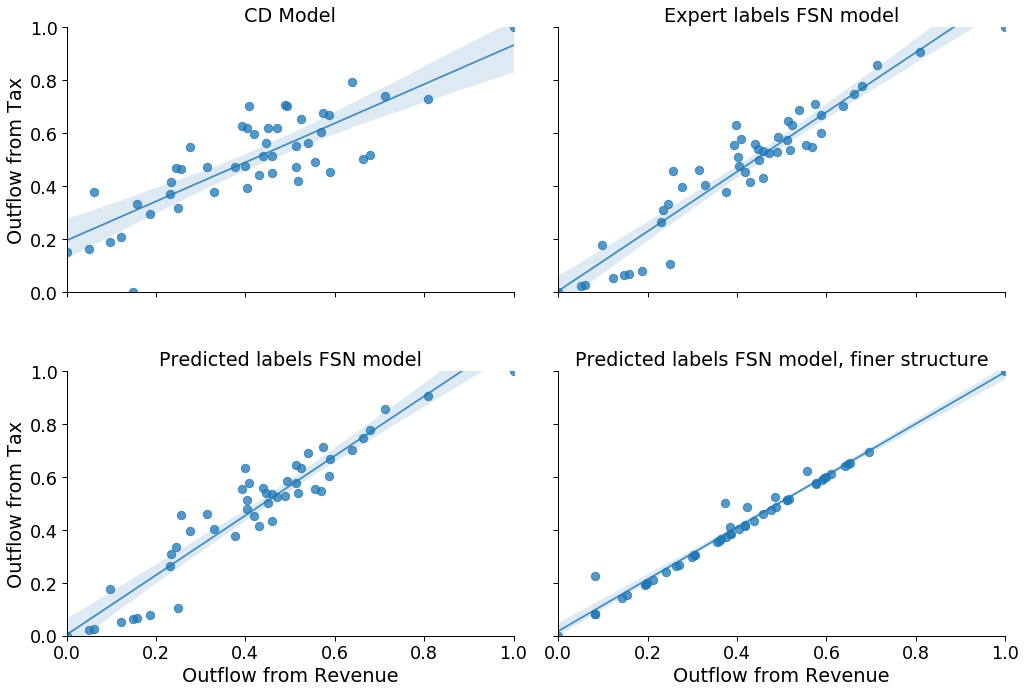

In [146]:
plotRegression(TAX_REVENUE_DF, title="img/Modelling/Latest/TaxRevenue_week")

# Trade receivables plausible relationship, from Marcel's paper

In [185]:
TR_DF = pd.DataFrame()

## Trade receivables plausible relationship on FA Names
Credit-debit model (CD) which uses only the in- and outflow but no process information

Started aggregation...


Correlation for given query and given shifts (0, -2) is           0.7760341152227572
0.15310322232181464


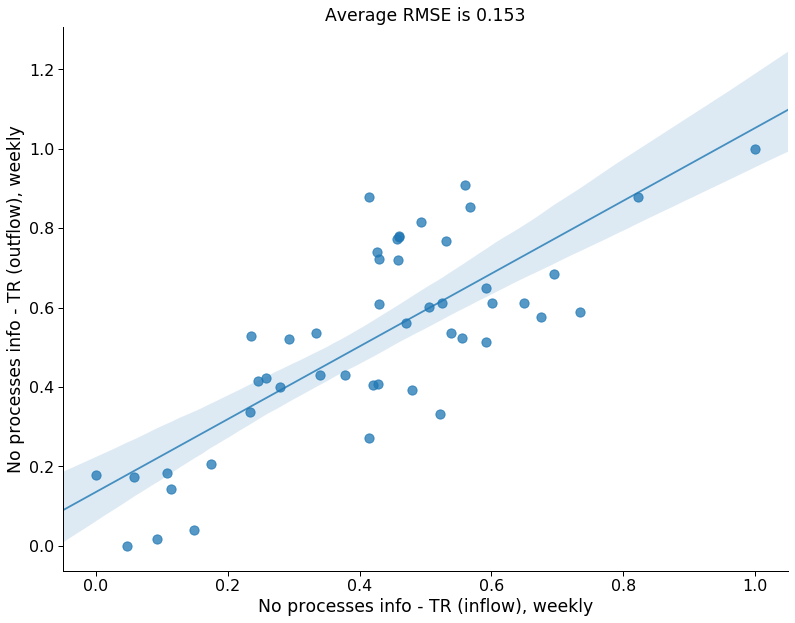

In [203]:
cur_result = constructSignals(df_all, shift=(0, -2), query=[{"select": ["ALL"], 
                              "_with": {"FA_Name": "TradeReceivables", "flow": "inflow"}}, 
                                {"select": ["ALL"], "_with": {"FA_Name": "TradeReceivables", "flow": "outflow"}}], 
                 on="label", agg_period="W", 
                title="img/Modelling/latest/CD_Model_TR_",
                legend=["No processes info - TR (inflow)", "No processes info - TR (outflow)"],
                metric="RMSE")
TR_DF = TR_DF.append(cur_result.assign(Model="CD Model"))

## Process-based model, GroundTruth

Started aggregation...


Correlation for given query and given shifts (0, -2) is           0.7760341152227572
0.15310322232181464


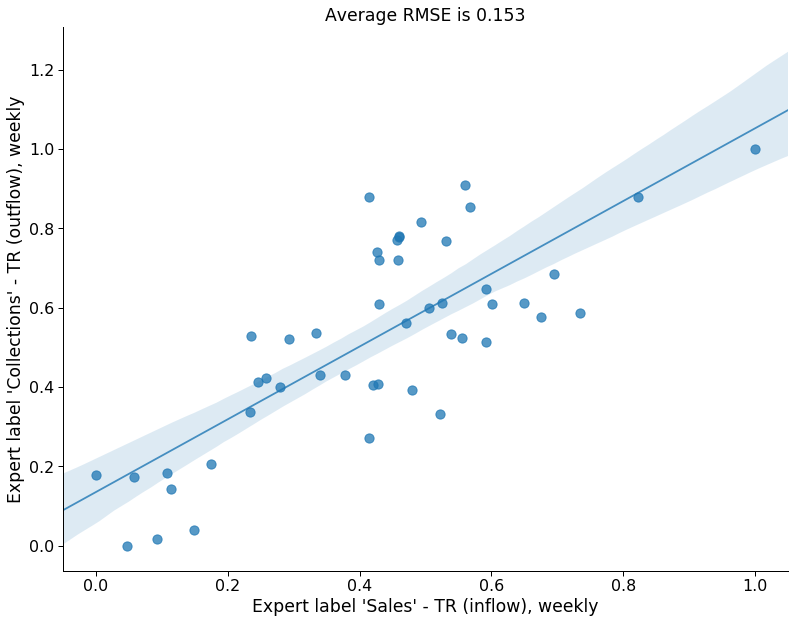

In [207]:
cur_result = constructSignals(df_all, shift=(0, -2), query=[{"select": ["Sales 21 btw", "Sales 6 btw"], 
                              "_with": {"FA_Name": "TradeReceivables", "flow": "inflow"}}, 
                                {"select": ["Collections"], "_with": {"FA_Name": "TradeReceivables", "flow": "outflow"}}], 
                 on="GroundTruth", agg_period="W", 
                title="img/Modelling/latest/expertFSN_TR_",
                legend=["Expert label 'Sales' - TR (inflow)", "Expert label 'Collections' - TR (outflow)"],
                metric="RMSE")
TR_DF = TR_DF.append(cur_result.assign(Model="Expert labels FSN model"))

## Process-based model, predicted label

In [208]:
labels_to_titles

{0: 'Goods delivery',
 1: 'Collections',
 2: 'Collections',
 3: 'Sales tax',
 4: 'Payroll',
 5: 'Sales 21 btw',
 6: 'Disbursement',
 7: 'Depreciation',
 8: 'Payroll Disbursement',
 9: 'Fixed Assets',
 10: 'Sales 6 btw',
 11: 'Purchase'}

Started aggregation...


Correlation for given query and given shifts (0, -2) is           0.7760341152227572
0.15310322232181464


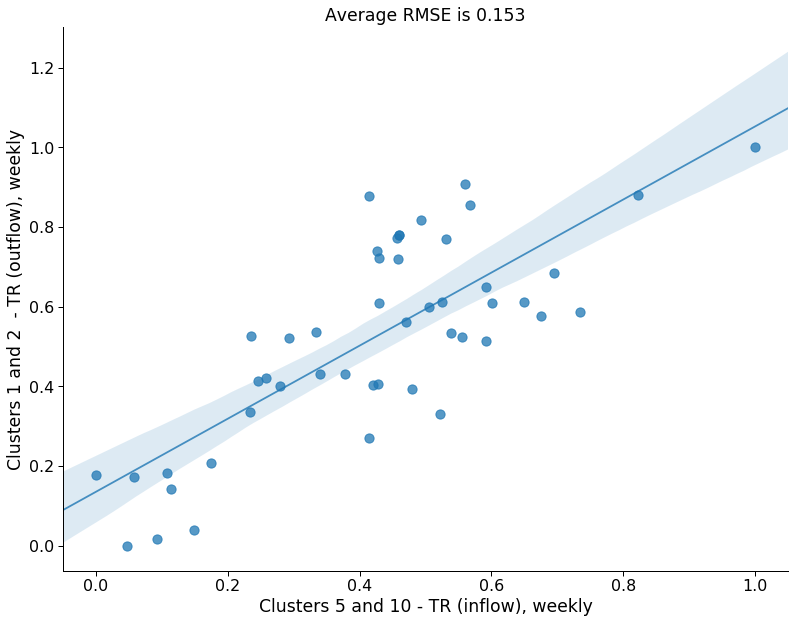

Started aggregation...


Correlation for given query and given shifts (0, -2) is           0.09017387865736777
0.21766292014563668


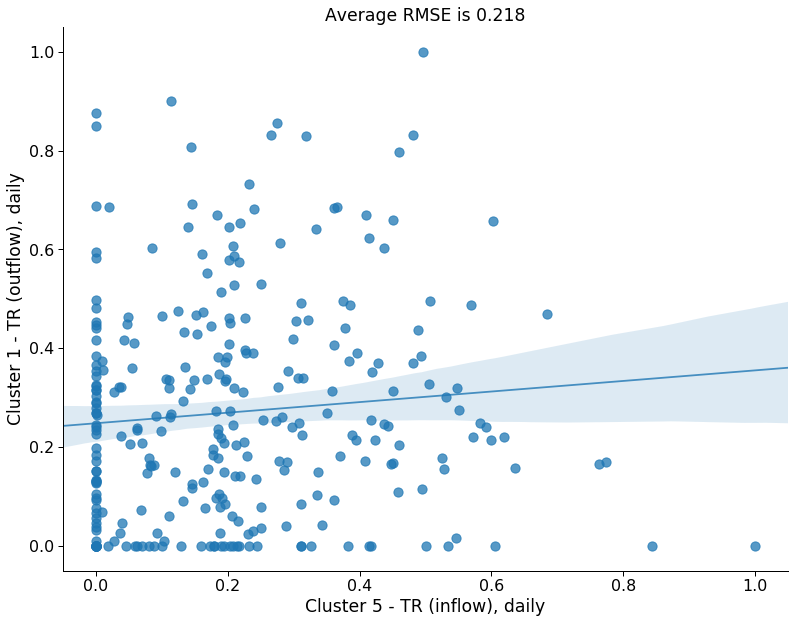

In [209]:
# ~Sales both
cur_result = constructSignals(df_all, shift=(0, -2), query=[{"select": [5, 10], 
                              "_with": {"FA_Name": "TradeReceivables", "flow": "inflow"}}, 
                                {"select": [1, 2], "_with": {"FA_Name": "TradeReceivables", "flow": "outflow"}}], on="label", agg_period="W", 
                    title="img/Modelling/Latest/aFSN_TR_v2_",
                    legend=["Clusters 5 and 10 - TR (inflow)", "Clusters 1 and 2  - TR (outflow)"],
                metric="RMSE")
TR_DF = TR_DF.append(cur_result.assign(Model="Predicted labels FSN model"))
# Sales 6
# ~Sales both
cur_result = constructSignals(df_all, shift=(0, -2), query=[{"select": [5], 
                              "_with": {"FA_Name": "TradeReceivables", "flow": "inflow"}}, 
                                {"select": [1], "_with": {"FA_Name": "TradeReceivables", "flow": "outflow"}}], on="label", agg_period="D", 
                    title="img/Modelling/Latest/aFSN_TR_v2_6_",
                    legend=["Cluster 5 - TR (inflow)", "Cluster 1 - TR (outflow)"],
                metric="RMSE")
TR_DF = TR_DF.append(cur_result.assign(Model="Predicted labels FSN model, finer structure"))

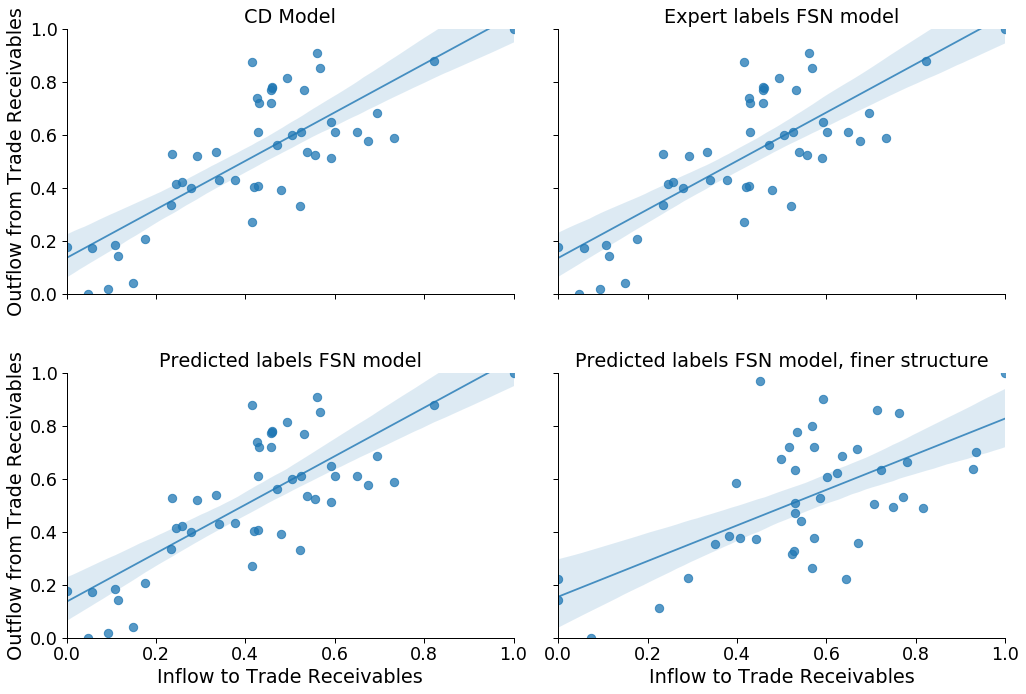

In [189]:
plotRegression(TR_DF, labels=["Inflow to Trade Receivables", "Outflow from Trade Receivables"],
                title="img/Modelling/Latest/TR_week")

## Cash plausible relationship

In [237]:
labels_to_titles

{0: 'Goods delivery',
 1: 'Collections',
 2: 'Collections',
 3: 'Sales tax',
 4: 'Payroll',
 5: 'Sales 21 btw',
 6: 'Disbursement',
 7: 'Depreciation',
 8: 'Payroll Disbursement',
 9: 'Fixed Assets',
 10: 'Sales 6 btw',
 11: 'Purchase'}

Started aggregation...


Correlation for given query and given shifts (0, 0) is           -0.05225714007389314
0.2402312892940782


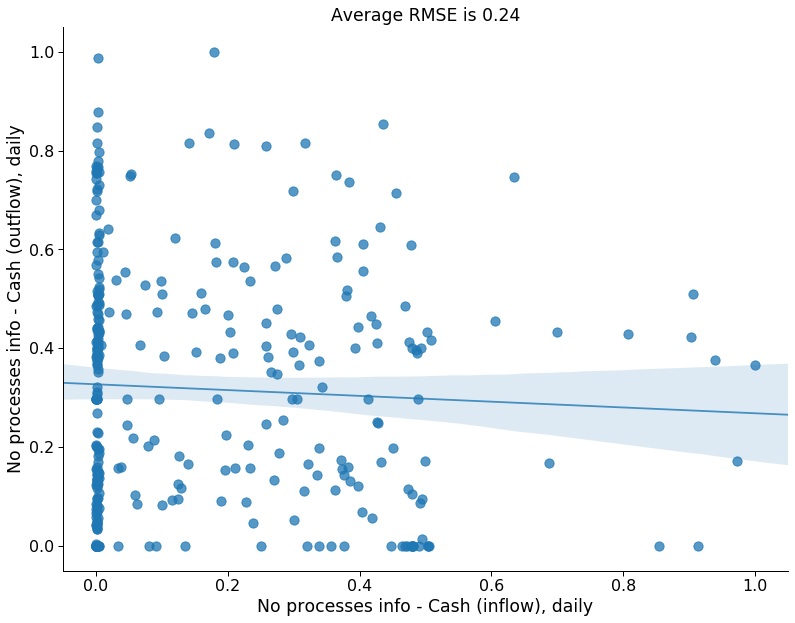

Started aggregation...


Correlation for given query and given shifts (0, 0) is           0.3618275779344293
0.16606697254751976


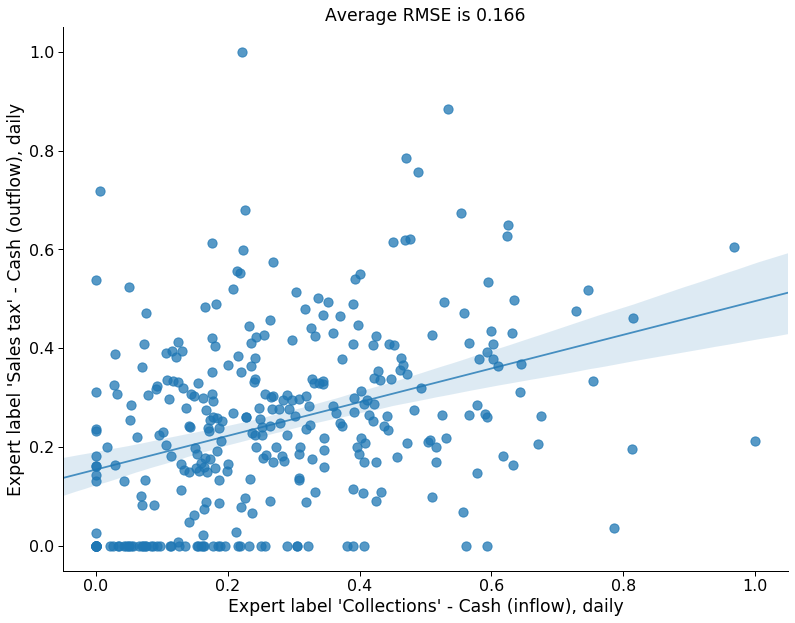

Started aggregation...


Correlation for given query and given shifts (0, 0) is           0.8701272693829565
0.11400166171296289


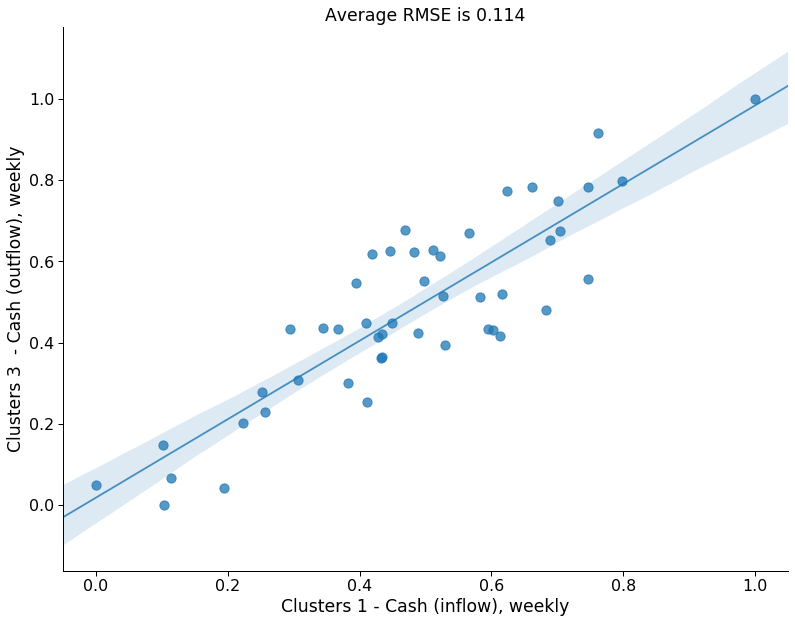

Started aggregation...


Correlation for given query and given shifts (0, 0) is           0.23876083975095394
0.17367765241265204


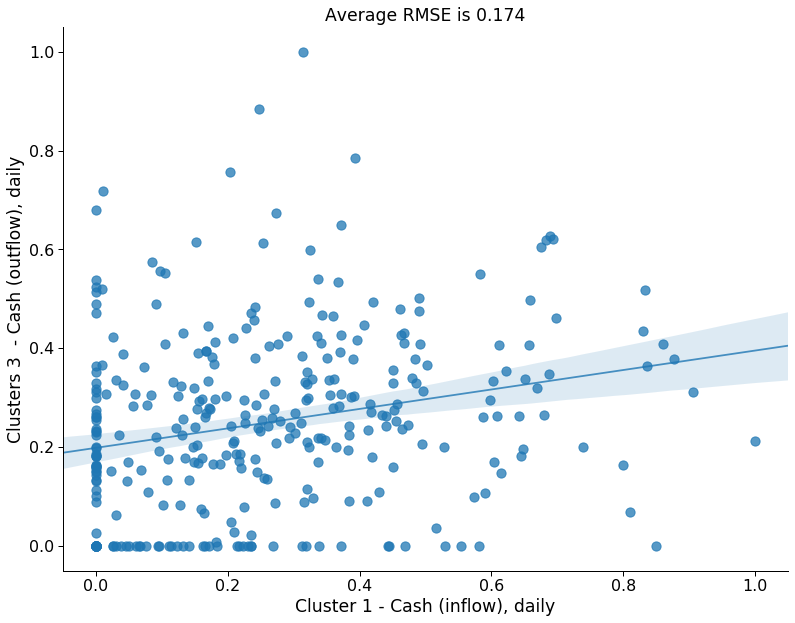

In [242]:
CASH_DF = pd.DataFrame()
cur_result = constructSignals(df_all, shift=(0, 0), query=[{"select": ["ALL"], 
                              "_with": {"FA_Name": "Cash", "flow": "inflow"}}, 
                                {"select": ["ALL"], "_with": {"FA_Name": "Cash", "flow": "outflow"}}], 
                 on="label", agg_period="D", 
                title="img/Modelling/latest/CD_Model_Cash_",
                legend=["No processes info - Cash (inflow)", "No processes info - Cash (outflow)"],
                metric="RMSE")
CASH_DF = CASH_DF.append(cur_result.assign(Model="CD Model"))
# 
cur_result = constructSignals(df_all, shift=(0, 0), query=[{"select": ["Collections"], 
                              "_with": {"FA_Name": "Cash", "flow": "inflow"}}, 
                                {"select": ["Sales tax"], "_with": {"FA_Name": "Cash", "flow": "outflow"}}], 
                 on="GroundTruth", agg_period="D", 
                title="img/Modelling/latest/expertFSN_Cash_",
                legend=["Expert label 'Collections' - Cash (inflow)", "Expert label 'Sales tax' - Cash (outflow)"],
                metric="RMSE")
CASH_DF = CASH_DF.append(cur_result.assign(Model="Expert labels FSN model"))
# 
# ~Sales both
cur_result = constructSignals(df_all, shift=(0, 0), query=[{"select": [1, 2], 
                              "_with": {"FA_Name": "Cash", "flow": "inflow"}}, 
                                {"select": [3], "_with": {"FA_Name": "Cash", "flow": "outflow"}}], on="label", agg_period="W", 
                    title="img/Modelling/Latest/aFSN_Cash_v2_",
                    legend=["Clusters 1 - Cash (inflow)", "Clusters 3  - Cash (outflow)"],
                metric="RMSE")
CASH_DF = CASH_DF.append(cur_result.assign(Model="Predicted labels FSN model"))
# ~Sales both
cur_result = constructSignals(df_all, shift=(0, 0), query=[{"select": [1], 
                              "_with": {"FA_Name": "Cash", "flow": "inflow"}}, 
                                {"select": [3], "_with": {"FA_Name": "Cash", "flow": "outflow"}}], on="label", agg_period="D", 
                    title="img/Modelling/Latest/aFSN_Cash1_v2_",
                    legend=["Cluster 1 - Cash (inflow)", "Clusters 3  - Cash (outflow)"],
                metric="RMSE")
CASH_DF = CASH_DF.append(cur_result.assign(Model="Predicted labels FSN model"))

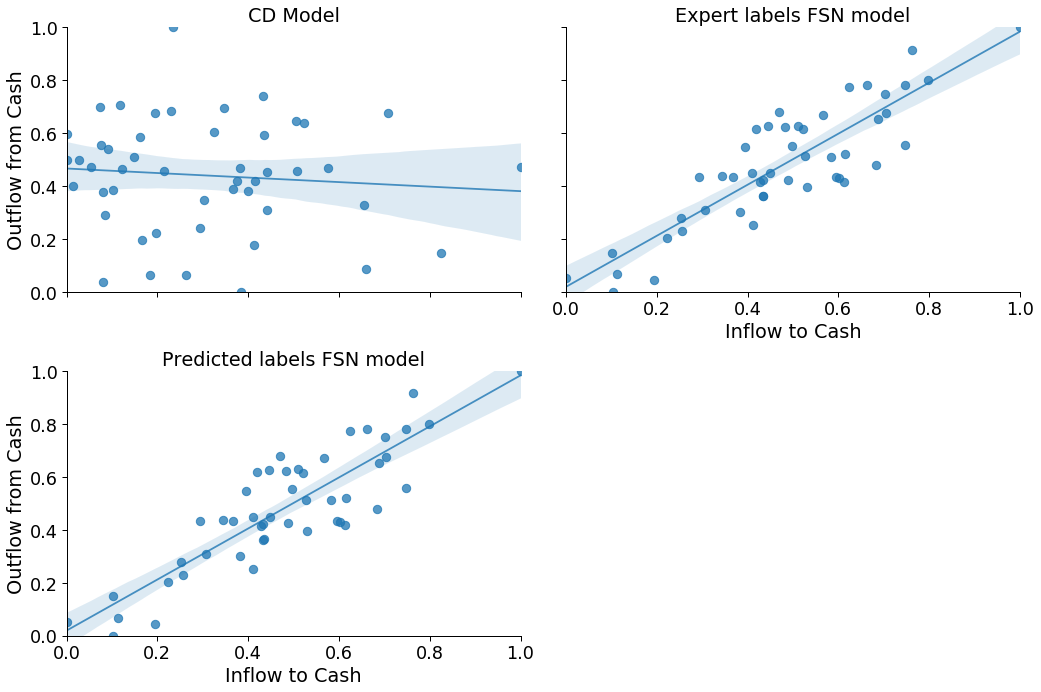

In [236]:
plotRegression(CASH_DF, labels=["Inflow to Cash", "Outflow from Cash"],
                title="img/Modelling/Latest/Cash_week")

In [58]:
from plotly.offline import iplot
import plotly.figure_factory as ff
import seaborn as sns
def calculate_corr(df_all, query=[1, 2], on="label", agg_period="2D", lag=0):
    X, Y = [df_all[df_all[on]==q] for q in query]
    return crosscorr(X.amount.resample(agg_period).sum(), Y.amount.resample(agg_period).sum(), lag)

def get_corr_matrix(df, on="label", agg_period="D", lag=0):
    labels = sorted(df[on].unique())
    corr_matrix = np.zeros((len(labels), len(labels)))
    for x_pos, x in enumerate(labels):
        for y_pos, y in enumerate(labels):
            if x!=y:
                try:
                    corr_matrix[x_pos, y_pos] = calculate_corr(df, query=[x,y], on=on, agg_period=agg_period, lag=lag)
                except FloatingPointError as float_er:
                    corr_matrix[x_pos, y_pos] = 0.0
    return corr_matrix

axis_prefix = {"label": "Cluster ", "GroundTruth": ""}


def make_annotations(z, x, y, annotation_text):
    annotations = []
    for n, row in enumerate(z):
        for m, val in enumerate(row):
            annotations.append(
                go.layout.Annotation(
                    text=str(annotation_text[n][m]) if annotation_text[n][m] != 0.0 else "",
                    x=x[m],
                    y=y[n],
                    xref='x1',
                    yref='y1',
                    font=dict(color="Black"),
                    showarrow=False))
    return annotations


def corrHeatmap_interactive(corr_matrix, labels, on="label"):
    x = [axis_prefix[on] + str(cl) for cl in labels]
    y = [axis_prefix[on] + str(cl) for cl in labels]
    # Generate a mask for the upper triangle
    mask = np.ones_like(corr_matrix, dtype=np.bool)
    mask[np.tril_indices_from(mask, k=0)] = False
    corr_matrix[mask] = 0.0
    z_text = np.round(corr_matrix, 2)
    cs = [[00.0, 'rgb(31, 119, 180)'],  # blue
          [0.5, 'rgb(255,255,255)'],  # white
          [1, 'rgb(214, 39, 40)']]  # red

    trace = go.Heatmap(z=corr_matrix, x=x, y=y, zmid=0, zmin=-1, zmax=1, colorscale=cs, showscale=True,
                       colorbar={"thickness": 20, "len": 0.5, "outlinewidth": 0, "xpad": 25,
                                 "title": {"text": "\n \n Correlation", "side": "right"}})
    fig = go.Figure(data=[trace])
    fig.layout.title = go.layout.Title(text="Cross-correlation for the " + on)
    fig.layout.height = len(labels) * 70 + 200
    fig.layout.width = len(labels) * 70 + 25 + 25 + 150
    fig.layout.margin = go.layout.Margin(l=100, r=50, b=100, t=200, pad=10)
    fig.layout.annotations = make_annotations(corr_matrix, x, y, z_text)
    fig.layout.xaxis.side = "top"
    fig.layout.yaxis.automargin = True
    fig.layout.xaxis.automargin = True
    iplot(fig)


def corrHeatmap_static(corr_matrix, labels, on="label"):
    sns.set_context("paper", rc={'figure.figsize': (20, 10), "font.size": 12, "axes.titlesize": 16, "axes.labelsize": 20,
                        "xtick.labelsize": 12, "ytick.labelsize": 12})
    x_ticks = [axis_prefix[on] + str(cl) for cl in labels]
    y_ticks = [axis_prefix[on] + str(cl) for cl in labels]
    z_text = np.round(corr_matrix, 2)
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr_matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    sns.heatmap(corr_matrix, mask=mask, annot=z_text, cmap="RdBu_r", vmin=-1, vmax=1, center=0, xticklabels=x_ticks,
                yticklabels=y_ticks,
                square=True, linewidths=.1, cbar_kws={"shrink": .5})
    ax.set_title("Cross-correlation for the " + on)
    plt.tight_layout()
    plt.plot()
    
def correlationMatrix(df, on="label", agg_period="D", lag=0, interactive=True):
    corr_matrix = get_corr_matrix(df, on=on, agg_period=agg_period, lag=lag)
    labels = sorted(df[on].unique())
    if interactive:
#         Use plotly
        return corrHeatmap_interactive(corr_matrix, labels=labels, on=on)
    else:
#         Use seaborn for visualization
        corrHeatmap_static(corr_matrix, labels=labels, on=on)

In [59]:
correlationMatrix(df_all, on="label", agg_period="D", interactive=True)
correlationMatrix(df_all, on="GroundTruth", agg_period="D", interactive=True)

## Clusters 0 and 2 in detail

In [ ]:
cl_0 = df_all[df_all["label"] == 2]
cl_0_D = cl_0.amount.resample("D").sum()
cl_2 = df_all[df_all["label"] == 6]
cl_2_D = cl_2.amount.resample("D").sum()

In [ ]:
from scipy import stats
try:
    print(stats.pearsonr(cl_0_D, cl_2_D), stats.spearmanr(cl_0_D, cl_2_D))
except:
    print(stats.pearsonr(cl_0_D, cl_2_D[:-1]), stats.spearmanr(cl_0_D, cl_2_D[:-1]))

In [ ]:
cl_0.resample("D").agg({"amount": sum}).rename(columns={"amount": "Cluster 0"}).head(2)

In [752]:
pairs = [make_pairs2(seq) for seq in sequences]

In [750]:
def make_pairs2(sampled_seq):
    """
    Helper function for construction pairs from sequence of nodes with given window size
    :param sampled_seq: Original sequence of nodes (output of RandomWalk procedure)
    !NOTE: Window size is used from CONFIG file for better performance!
    :return:
    """
    output = list()
    try:
        for cur_idx in range(len(sampled_seq)):
            for drift in range(cur_idx, min(cur_idx + 1+1, len(sampled_seq))):
                if drift != cur_idx:
                    output.append((sampled_seq[cur_idx], sampled_seq[drift]))
        return output
    except TypeError:
        pass

In [754]:
import itertools
pairs = list(itertools.chain(*pairs))

In [755]:
pairs_no = [item for item in pairs if item[0] != item[1]]

In [758]:
len(pairs)-len(pairs_no)

3281